# Running different algorithms

### Importing libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
import seaborn as sns

### Defining path to data

In [2]:
#path = 'C:/Users/Marie/Desktop/MSc DSBA/4. Machine Learning/3. Project/clean_data/'
path = 'C:/Users/Romain/Documents/230 - MSC ESSEC/304 - Machine Learning/01 - Kaggle/clean_data/'

In [3]:
print(listdir(path))

['age_opti_GB.csv', 'age_opti_GB_0.8.csv', 'age_opti_GB_0.9.csv', 'age_opti_GB_2_0.5.csv', 'age_opti_GB_2_0.6.csv', 'age_opti_LA.csv', 'age_opti_LA_2.csv', 'age_opti_RF.csv', 'age_opti_RF_1.csv', 'age_opti_RF_2.csv', 'age_opti_RF_3.csv', 'age_opti_RI.csv', 'age_opti_RI_2.csv', 'age_without_opti.csv', 'test.csv', 'train.csv']


### Loading train data

In [4]:
#train = pd.read_csv(path + 'train.csv')
#test = pd.read_csv(path + 'test.csv')

train = pd.read_csv(path + 'train.csv', index_col='user_id')
test = pd.read_csv(path + 'test.csv', index_col='user_id')
#targets = pd.read_csv(path + 'targets_flat.csv', dtype={"user_id":object, "country_destination":object}, index_col=['user_id'])
#targets_train = targets[targets.country_destination.notnull()].values.reshape(-1,)

In [5]:
train['train']=1
test['train']=0

df = pd.concat([train, test], ignore_index=True, axis=0)
df = df.drop([x for x in df.columns if 'gender' in x], axis=1)

In [6]:
df[(df['age']<14)|(df['age']>85)] = np.nan

In [7]:
predi = df[df['age'].isnull()]
df = df.drop(df[df['age'].isnull()].index, axis=0)

In [8]:
print(df.shape, predi.shape)

(155581, 102) (119966, 102)


## Predicting Ages

In [9]:
target = df['age']
df = df.drop('age', axis=1)

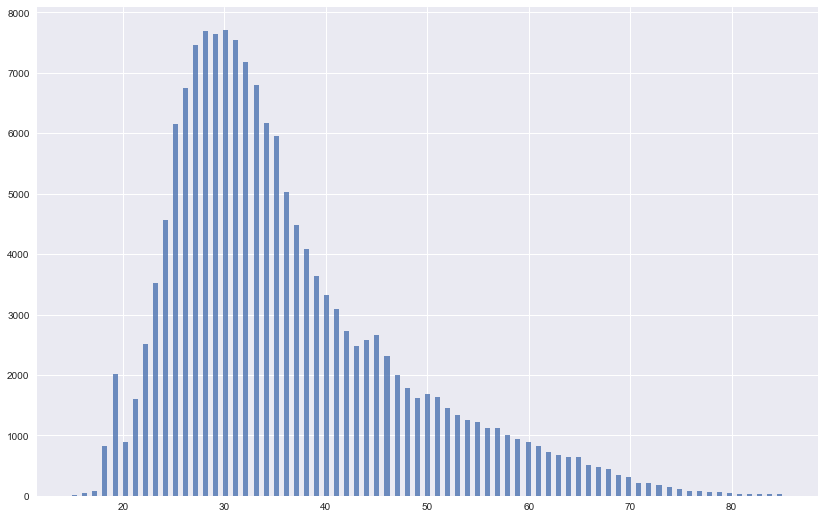

In [10]:
target.hist(bins=target.unique().size*2-1, figsize=(14,9), alpha=0.8)
plt.show()

### 1 - Importing libraries

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [12]:
from sklearn.model_selection import KFold
from scipy.stats import kstest, poisson
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso

In [14]:
print(df.shape, predi.shape)

(155581, 101) (119966, 102)


In [15]:
df = df.drop('train', axis=1)

### 2 - Compute MSE if we fill age with Mean or Median

In [16]:
mse_mean_tot = []
mse_median_tot = []

kf = KFold(n_splits=5 , shuffle=False)
for train_index, test_index in kf.split(df):

    df_train, df_test = df.loc[train_index, :].dropna(), df.loc[test_index, :].dropna()
    target_train = pd.DataFrame(target).loc[train_index, :].dropna()
    target_test = pd.DataFrame(target).loc[test_index, :].dropna()
    
    target_test_mean_medi = pd.DataFrame()
    target_test_mean_medi['age'] = target_test
    target_test_mean_medi['mean_'] = int(target_train.mean())
    target_test_mean_medi['median_'] = int(target_train.median())
    
    mse_mean = mean_squared_error(target_test, np.ravel(target_test_mean_medi.mean_))
    mse_median = mean_squared_error(target_test, np.ravel(target_test_mean_medi.median_))
    
    print('MSE mean : ', mse_mean)
    print('MSE median : ', mse_median)
    
    mse_mean_tot.append(mse_mean)
    mse_median_tot.append(mse_median)
    
    print('='*50)

print('='*50)
print('MSE MEAN TOTAL : ', np.mean(mse_mean_tot), ' (+/- ', 2*np.std(mse_mean_tot), ')')
print('MSE MEDIAN TOTAL : ', np.mean(mse_median_tot), ' (+/- ', 2*np.std(mse_median_tot), ')')

MSE mean :  124.050805697
MSE median :  135.082392943
MSE mean :  127.917337235
MSE median :  137.64834361
MSE mean :  132.187887866
MSE median :  140.370639846
MSE mean :  134.112379549
MSE median :  140.947216596
MSE mean :  129.302478745
MSE median :  128.025386181
MSE MEAN TOTAL :  129.514177818  (+/-  6.97052858081 )
MSE MEDIAN TOTAL :  136.414795835  (+/-  9.37531532098 )


### 3 - Compute MSE with some algorithms without optimization

#### Function to compute MSE with a certain model, with a kfold decomposition

In [17]:
def fun_mse_kfold(my_MODEL , kf = KFold(n_splits=5 , shuffle=False)):
    mse_MODEL_tot = []
    
    print(my_MODEL)
    print('='*30)

    for train_index, test_index in kf.split(df):

        df_train, df_test = df.loc[train_index, :].dropna(), df.loc[test_index, :].dropna()
        target_train = pd.DataFrame(target).loc[train_index, :].dropna()
        target_test = pd.DataFrame(target).loc[test_index, :].dropna()

        my_MODEL = my_MODEL.fit(df_train, np.ravel(target_train))

        mse = mean_squared_error(target_test, my_MODEL.predict(df_test))

        print('MSE MODEL : ', mse, ' // ', df_train.shape, df_test.shape)
        mse_MODEL_tot.append(mse)

    print('='*50)    
    print('MSE GLOBAL : ', np.mean(mse_MODEL_tot), ' (+/- ', 2*np.std(mse_MODEL_tot), ')')

    return

In [18]:
def fun_mse_kfold_boucle(my_MODEL ,
                         kf = KFold(n_splits=5 , shuffle=False),
                         result = []):
    mse_MODEL_tot = []
    
    print(my_MODEL)

    for train_index, test_index in kf.split(df):

        df_train, df_test = df.loc[train_index, :].dropna(), df.loc[test_index, :].dropna()
        target_train = pd.DataFrame(target).loc[train_index, :].dropna()
        target_test = pd.DataFrame(target).loc[test_index, :].dropna()

        my_MODEL = my_MODEL.fit(df_train, np.ravel(target_train))

        mse = mean_squared_error(target_test, my_MODEL.predict(df_test))

        mse_MODEL_tot.append(mse)

    print('='*50)    
    print('MSE GLOBAL : ', np.mean(mse_MODEL_tot), ' (+/- ', 2*np.std(mse_MODEL_tot), ')')
    print('='*75)

    result.append([np.mean(mse_MODEL_tot), np.std(mse_MODEL_tot), my_MODEL])
    
    return result

#### Compute MSE for different algo

In [19]:
list_algo = []
list_algo.append(RandomForestRegressor(n_jobs=7))
list_algo.append(Lasso())
list_algo.append(Ridge())
list_algo.append(LinearRegression(n_jobs=7))
list_algo.append(GradientBoostingRegressor())

In [20]:
to_do = False

if to_do == True:
    result = []
    for A in list_algo:
        fun_mse_kfold_boucle(my_MODEL=A, result=result)

    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_without_opti.csv', index=True)
else:
    result_df = pd.read_csv(path+'age_without_opti.csv', index_col=0)
    print(result_df)

            MSE           STD  \
0  1.377461e+02  2.744734e+00   
1  1.279270e+02  3.785785e+00   
2  1.180025e+02  2.558125e+00   
3  6.086078e+11  1.217216e+12   
4  1.172896e+02  2.687898e+00   

                                                ALGO  
0  RandomForestRegressor(bootstrap=True, criterio...  
1  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
2  Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...  
3  LinearRegression(copy_X=True, fit_intercept=Tr...  
4  GradientBoostingRegressor(alpha=0.9, criterion...  


In [21]:
fun_mse_kfold(my_MODEL=LinearRegression(n_jobs=7))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=7, normalize=False)
MSE MODEL :  114.069992382  //  (70825, 100) (20293, 100)
MSE MODEL :  3.04303912486e+12  //  (71980, 100) (19138, 100)
MSE MODEL :  119.890757962  //  (72426, 100) (18692, 100)
MSE MODEL :  121.256790242  //  (74825, 100) (16293, 100)
MSE MODEL :  118.266656499  //  (74416, 100) (16702, 100)
MSE GLOBAL :  608607825067.0  (+/-  2.4344312998e+12 )


### 4 - Optimization
#### i - Random Forest Regressor

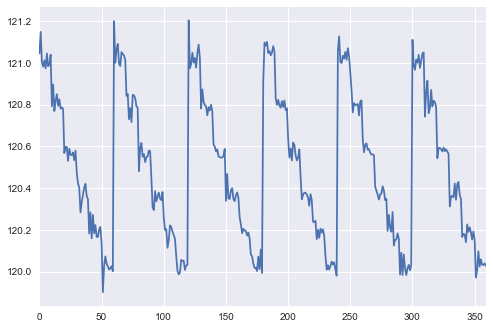

In [22]:
to_do_RF = False

if to_do_RF == True:
    result=[]
    for i in range(8,14): #max_depth
        for j in range(8,14): #max_leaf_nodes
            for k in range(10,110,10): #n_estimators
                fun_mse_kfold_boucle(my_MODEL=RandomForestRegressor(n_jobs=7, max_depth=i, max_leaf_nodes=j, n_estimators=k),
                                     result=result)
        print(i)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RF.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RF.csv', index_col=0)
    result_df['MSE'].plot()
    plt.show()

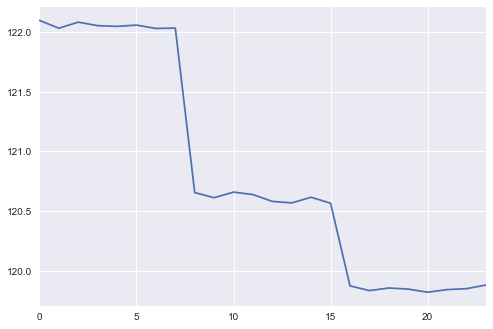

In [23]:
to_do_RF_1 = False

max_depth = range(3,6)
n_estimators = range(50, 130, 10)


if to_do_RF_1 == True:
    result=[]
    for i in max_depth:
        for j in n_estimators:
            fun_mse_kfold_boucle(my_MODEL=RandomForestRegressor(n_jobs=7, max_depth=i, n_estimators=j),
                                     result=result)
        print(i)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RF_1.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RF_1.csv', index_col=0)
    result_df['MSE'].plot()
    plt.show()

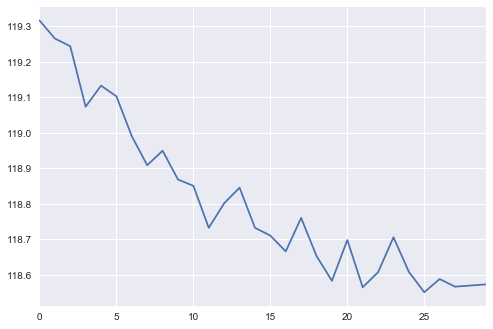

In [24]:
to_do_RF_2 = False


max_leaf_nodes = range(20,50)


if to_do_RF_2 == True:
    result=[]
    for i in max_leaf_nodes:
            fun_mse_kfold_boucle(my_MODEL=RandomForestRegressor(n_jobs=7, max_leaf_nodes=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RF_2.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RF_2.csv', index_col=0)
    result_df['MSE'].plot()

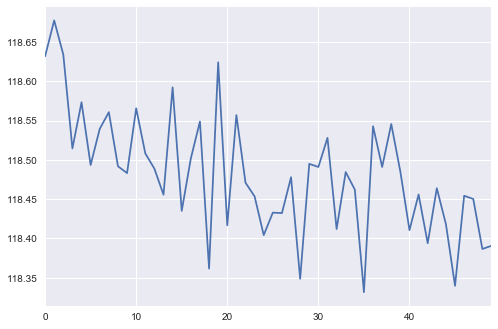

In [25]:
to_do_RF_3 = False


max_leaf_nodes = range(40,90)


if to_do_RF_3 == True:
    result=[]
    for i in max_leaf_nodes:
            fun_mse_kfold_boucle(my_MODEL=RandomForestRegressor(n_jobs=7, max_leaf_nodes=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RF_3.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RF_3.csv', index_col=0)
    result_df['MSE'].plot()

In [26]:
print(df.shape, predi.shape)

(155581, 100) (119966, 102)


In [27]:
list_algo

[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=7, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=7, normalize=False),
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min

#### ii - Lasso

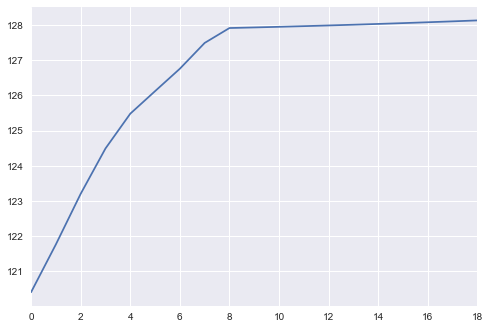

In [28]:
to_do_LA = False


param_1 = [x/10 for x in range(1,20)]


if to_do_LA == True:
    result=[]
    for i in param_1:
            fun_mse_kfold_boucle(Lasso(alpha=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_LA.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_LA.csv', index_col=0)
    result_df['MSE'].plot()

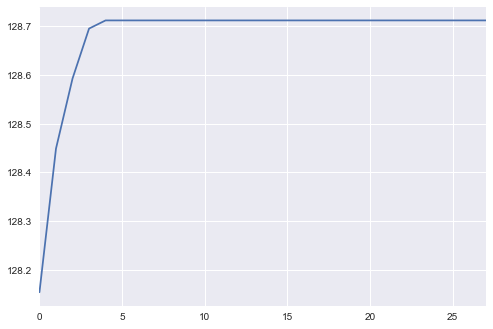

In [29]:
to_do_LA_2 = False


param_1 = range(2,30)


if to_do_LA_2 == True:
    result=[]
    for i in param_1:
            fun_mse_kfold_boucle(Lasso(alpha=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_LA_2.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_LA_2.csv', index_col=0)
    result_df['MSE'].plot()

#### iii - Ridge

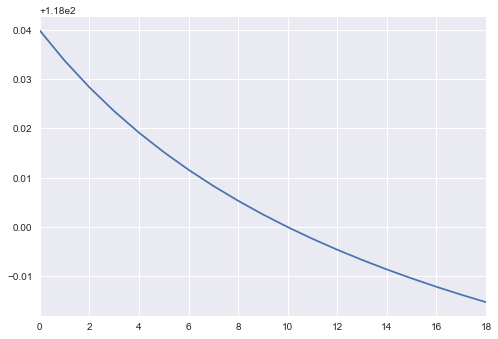

In [30]:
to_do_RI = False


param_1 = [x/10 for x in range(1,20)]


if to_do_RI == True:
    result=[]
    for i in param_1:
            fun_mse_kfold_boucle(Ridge(alpha=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RI.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RI.csv', index_col=0)
    result_df['MSE'].plot()

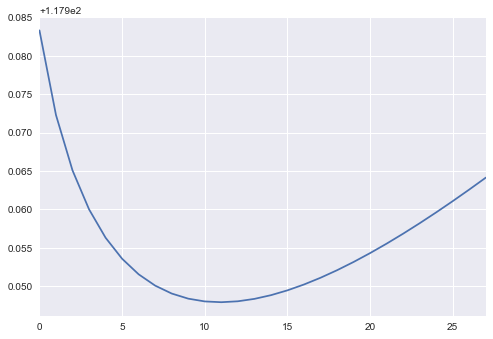

In [31]:
to_do_RI_2 = False


param_1 = range(2,30)


if to_do_RI_2 == True:
    result=[]
    for i in param_1:
            fun_mse_kfold_boucle(Ridge(alpha=i),
                                     result=result)
    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_RI_2.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_RI_2.csv', index_col=0)
    result_df['MSE'].plot()

#### iv - Gradient Boosting

In [32]:
GradientBoostingRegressor(max_leaf_nodes=None)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

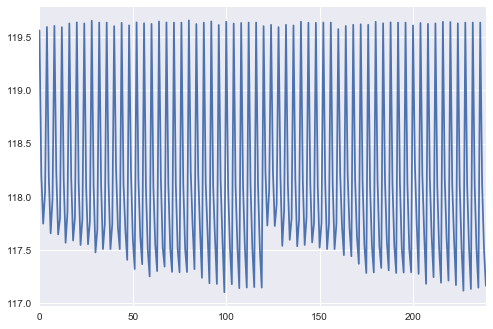

In [33]:
to_do_GB = False


param_1 = [x/10 for x in range(8,10)]
param_2 = [x for x in range(2,5)]
param_3 = [x for x in range(20,110,10)]
param_3.append(None)
param_4 = [x for x in range(2,5)]
param_4.append(None)

if to_do_GB == True:
    result=[]
    for i in param_1:
        for j in param_2:
            for k in param_3:
                for l in param_4:
                    fun_mse_kfold_boucle(GradientBoostingRegressor(alpha=i, max_depth=j, max_features=k, max_leaf_nodes=l), result=result)
            result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
            result_df.to_csv(path+'age_opti_GB_'+str(i)+'.csv', index=True)

    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_GB.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_GB.csv', index_col=0)
    result_df['MSE'].plot()

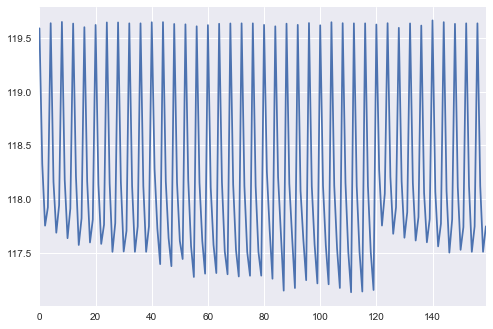

In [37]:
# ATTENTION JE L'AI FAIT EN DEUX FOIS !! AJOUTER age_opti_GB_2_0.5 avec le reste !!!
to_do_GB_2 = False


param_1 = [x/10 for x in range(6,8)]
param_2 = [x for x in range(2,5)]
param_3 = [x for x in range(20,110,10)]
param_3.append(None)
param_4 = [x for x in range(2,5)]
param_4.append(None)

if to_do_GB_2 == True:
    result=[]
    for i in param_1:
        for j in param_2:
            for k in param_3:
                for l in param_4:
                    fun_mse_kfold_boucle(GradientBoostingRegressor(alpha=i, max_depth=j, max_features=k, max_leaf_nodes=l), result=result)
            result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
            result_df.to_csv(path+'age_opti_GB_2_'+str(i)+'.csv', index=True)

    result_df = pd.DataFrame(result, columns=['MSE','STD','ALGO'])
    result_df.to_csv(path+'age_opti_GB_2.csv', index=True)
    
else:
    result_df = pd.read_csv(path+'age_opti_GB_2_0.6.csv', index_col=0)
    result_df['MSE'].plot()

#### v - Linear Reg

In [35]:
GradientBoostingRegressor(max_features=None)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [36]:
# ouvrir tous les csv qui contiennent age_opti, les concat, et regarder qui a fait le meilleur score !!

GradientBoostingRegressor(alpha=1)

GradientBoostingRegressor(alpha=1, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)